In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging
import tensorflow as tf
import cv2
import numpy as np
from PIL import Image
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
tf.get_logger().setLevel('ERROR')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.cluster import KMeans
import colorsys

import operator
%matplotlib inline
#inline 
#notebook

In [2]:
# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# convert image from BGR to RBG
def convert_bgr2rgb(img):
    conv_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return conv_img

#@tf.function
#def detect_fn(image):
    """Detect objects in image."""

#    image, shapes = detection_model.preprocess(image)
#    prediction_dict = detection_model.predict(image, shapes)
#    detections = detection_model.postprocess(prediction_dict, shapes)

#    return detections, prediction_dict, tf.reshape(shapes, [-1])

#category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,use_display_name=True)

In [3]:
def clustering(image, k):
    # function that creates clusters for the images in a folder and shows the images
    # pass images as rgb

    # reshape the image to a 2D array of pixels and 3 color values (RGB)
    pixel_values = image.reshape((-1, 3))

    # cluster the pixel intensities
    clt = KMeans(n_clusters = k)
    clt.fit(pixel_values)
        
    return clt

def create_segmented_image (image_shape, centers, labels):
    # convert back to 8 bit values
    centers = np.uint8(centers)

    # flatten the labels array
    labels = labels.flatten()

    # convert all pixels to the color of the centroids
    segmented_image = centers[labels.flatten()]
    
    # reshape back to the original image dimension
    segmented_image = segmented_image.reshape(image_shape)
    
    return segmented_image


def select_splash(labels, centers):
    i = 0
    splash_size = 0
    # select cluster based on colour of centers
    for colour in centers:
        # detect splash cluster through its higerh r value than other clusters
        if 130<colour[0] and 170<colour[1] and 190<colour[1]:
            # calculate splash size
            unique, counts = np.unique(labels, return_counts=True)
            a = dict(zip(unique, counts))
            splash_size = a[i]
            key = i
        else:
            i += 1
    
    return splash_size, key


def display_cluster(img1, clt, i):
    res = np.copy(img1)
    # keep only splash cluster in img2
    # keep only the cluster number i (turn other pixel into black)
    masked_image = np.copy(img1)

    # convert to the shape of a vector of pixel values
    masked_image = masked_image.reshape((-1, 3))
    # color (i.e cluster) to keep
    cluster = i
    masked_image[clt.labels_ != cluster] = [0, 0, 0]
    masked_image[clt.labels_ == cluster] = [255, 0, 0]
    # convert back to original shape and store in img2
    img2 = masked_image.reshape(img1.shape)
     
    # I want to put logo on top-left corner, So I create a ROI
    rows,cols,channels = img2.shape
    roi = img1[0:rows, 0:cols]
    
    # Now create a mask of logo and create its inverse mask also
    img2gray = cv2.cvtColor(img2,cv2.COLOR_RGB2GRAY)
    ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
    mask_inv = cv2.bitwise_not(mask)
    
    # Now black-out the area of logo in ROI
    img1_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)
    # Take only region of logo from logo image.
    img2_fg = cv2.bitwise_and(img2,img2,mask = mask)
    # Put logo in ROI and modify the main image
    dst = cv2.add(img1_bg,img2_fg)
    res[0:rows, 0:cols ] = dst
    
    return res

def display_cluster(img1, clt, i):
    res = np.copy(img1)
    # keep only splash cluster in img2
    # keep only the cluster number i (turn other pixel into black)
    masked_image = np.copy(img1)

    # convert to the shape of a vector of pixel values
    masked_image = masked_image.reshape((-1, 3))
    # color (i.e cluster) to keep
    cluster = i
    masked_image[clt.labels_ != cluster] = [0, 0, 0]
    masked_image[clt.labels_ == cluster] = [255, 0, 0]
    # convert back to original shape and store in img2
    img2 = masked_image.reshape(img1.shape)
     
    # I want to put logo on top-left corner, So I create a ROI
    rows,cols,channels = img2.shape
    roi = img1[0:rows, 0:cols]
    
    # Now create a mask of logo and create its inverse mask also
    img2gray = cv2.cvtColor(img2,cv2.COLOR_RGB2GRAY)
    ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
    mask_inv = cv2.bitwise_not(mask)
    
    # Now black-out the area of logo in ROI
    img1_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)
    # Take only region of logo from logo image.
    img2_fg = cv2.bitwise_and(img2,img2,mask = mask)
    # Put logo in ROI and modify the main image
    dst = cv2.add(img1_bg,img2_fg)
    res[0:rows, 0:cols ] = dst
    
    return res, mask

In [4]:
# predict and plot:
def predict_and_plot(image_name):
    
    ################### read in image:
    frame = np.array(Image.open('original_frames/' +image_name))
    
    ################### transform color:
    #print(frame.shape)
    #rgb_frame = np.array(Image.fromarray(frame[:, :, 0] > 235).convert("RGB"))
    
    ################### plot original:
    plt.imshow(frame)
    plt.show()
    
    ################### plot label image and label size:
    label_frame = np.array(Image.open('annotated_frames/' +image_name))
    
    label_mask = cv2.cvtColor(label_frame,cv2.COLOR_BGR2GRAY)
    label_mask[label_mask != 46] = 0
    label_mask[label_mask == 46] = 213

    label_size = sum(label_mask.flatten() != 0)
    plt.imshow(label_frame)
    plt.show()
    #print(label_size)
    
    ################### make prediction: 
    
    # clustering with k clusters
    clt = clustering(frame, k = 7)
    
    # create segmented image
    segmented_image = create_segmented_image(frame.shape, clt.cluster_centers_, clt.labels_)
    
    # select cluster with the splash and store size
    splash, spalsh_cluster_index = select_splash(clt.labels_, clt.cluster_centers_)

    # create overlayed image with splash cluster
    full_image, pred_mask = display_cluster(frame, clt, spalsh_cluster_index)
    # inverted mask needed for calculating the difference between prediction and reality
    # done by returning mask before inverting
    
    ################### plot prediction and print predicted size:
    plt.imshow(full_image)
    plt.show()
    if len(pred_mask) != 0:
        splash_size = sum(pred_mask.flatten() != 0)
        #print(splash_size)
    else:
        print('no splash')
    
    ################### calculate difference between original and prediction and accuracy
    if len(pred_mask) != 0:
        rows,cols,channels = frame.shape
        diff = cv2.absdiff(label_mask, pred_mask)
#         plt.imshow(label_mask)
#         plt.show()
#         plt.imshow(empty_image)
#         plt.show()
        plt.imshow(diff)
        plt.show()
        diff_size = sum(diff.flatten() != 0)
        #print(diff_size)
        accuracy = round((label_size - diff_size) / label_size,4)
        
    ################### safe calculation to a dictionairy
    frame_info = {
        'frame_name': image_name,
        'label_size': label_size,
    }
    if len(pred_mask) != 0:
        frame_info['splash_size'] = splash_size
        frame_info['diff_size'] = diff_size
        frame_info['accuracy'] = accuracy
    else:
        frame_info['splash_size'] = 0
        frame_info['diff_size'] = label_size
        frame_info['accuracy'] = 0
        
    print(frame_info)
    return frame_info

In [5]:
#making predictions for all frames in a directory
file_names = os.listdir('original_frames/')
file_names.remove('.ipynb_checkpoints')
predictions = []

In [6]:
# execute all cells below
from IPython.display import Javascript
display(Javascript('IPython.notebook.execute_cells_below()'))

<IPython.core.display.Javascript object>

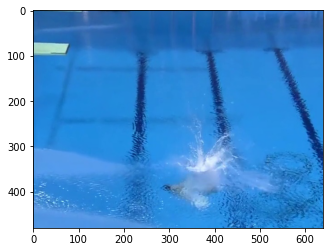

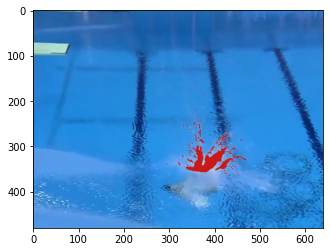

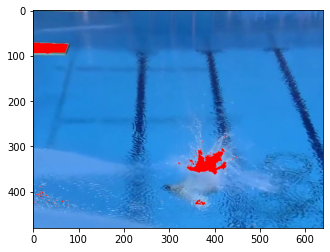

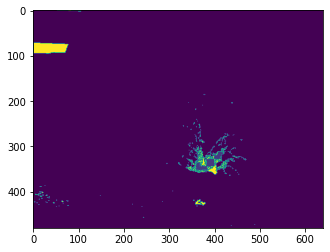

{'frame_name': '_tigfCJFLZg_00041.mp4_0153.0.jpg', 'label_size': 2048, 'splash_size': 4330, 'diff_size': 4976, 'accuracy': -1.4297}


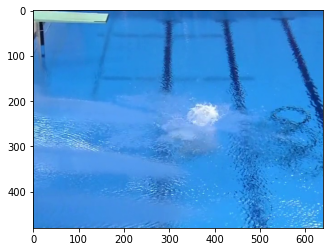

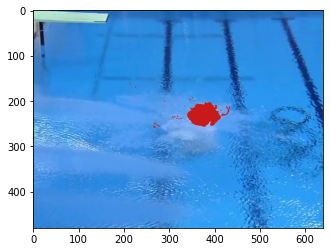

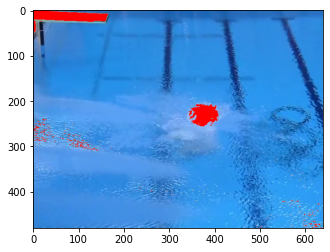

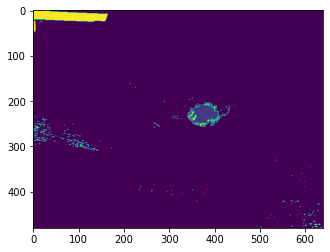

{'frame_name': '_tigfCJFLZg_00045.mp4_0193.0.jpg', 'label_size': 2497, 'splash_size': 6146, 'diff_size': 6711, 'accuracy': -1.6876}


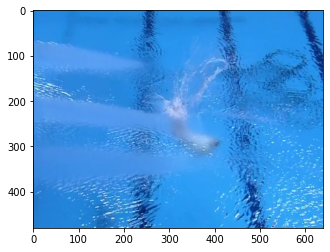

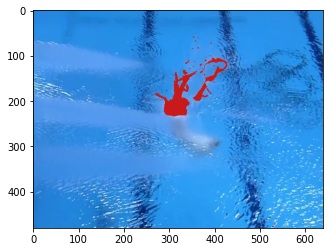

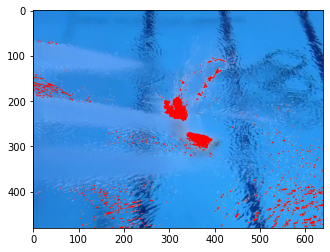

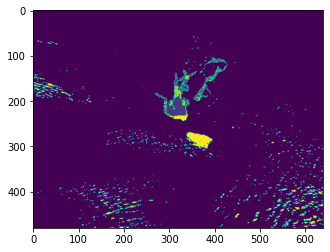

{'frame_name': '_tigfCJFLZg_00012.mp4_0140.0.jpg', 'label_size': 3413, 'splash_size': 8604, 'diff_size': 10391, 'accuracy': -2.0445}


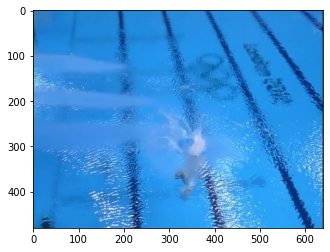

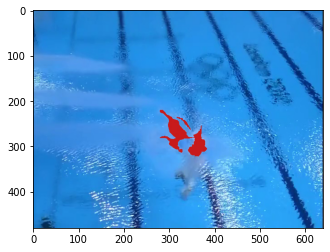

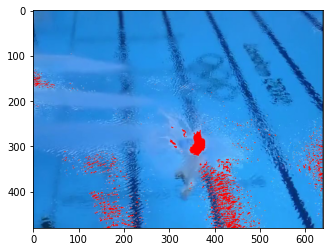

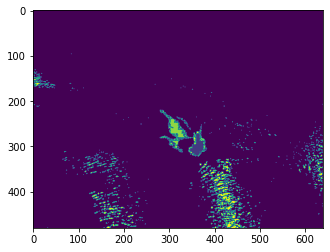

{'frame_name': '_tigfCJFLZg_00024.mp4_0108.0.jpg', 'label_size': 2566, 'splash_size': 7607, 'diff_size': 9131, 'accuracy': -2.5585}


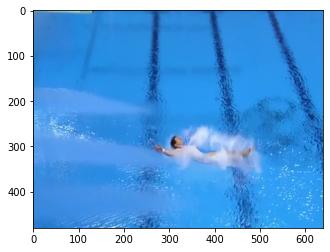

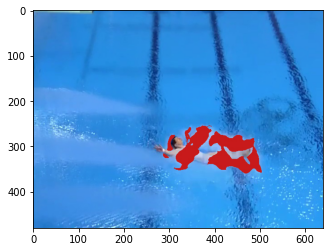

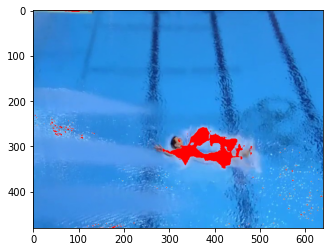

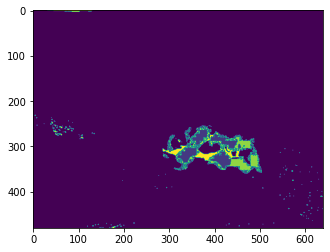

{'frame_name': '_tigfCJFLZg_00113.mp4_0126.0.jpg', 'label_size': 7316, 'splash_size': 6831, 'diff_size': 10247, 'accuracy': -0.4006}


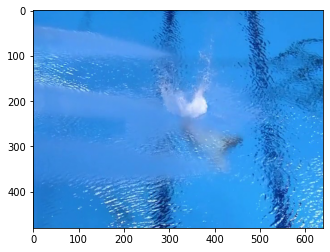

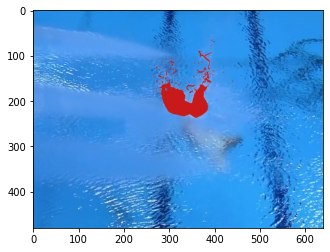

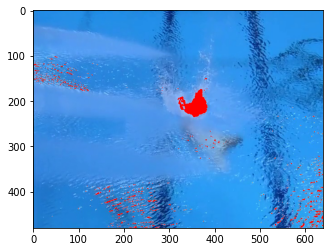

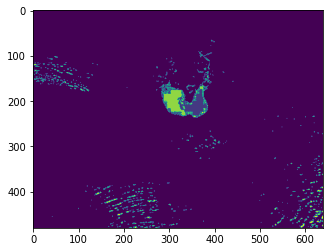

{'frame_name': '_tigfCJFLZg_00022.mp4_0141.0.jpg', 'label_size': 4492, 'splash_size': 4615, 'diff_size': 7265, 'accuracy': -0.6173}


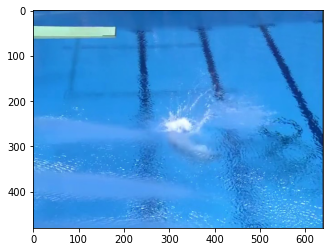

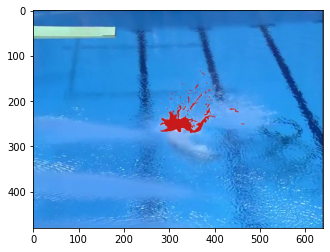

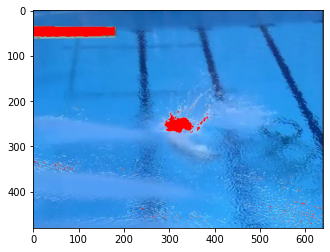

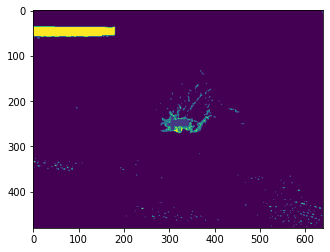

{'frame_name': '_tigfCJFLZg_00060.mp4_0034.0.jpg', 'label_size': 1930, 'splash_size': 5939, 'diff_size': 6652, 'accuracy': -2.4466}


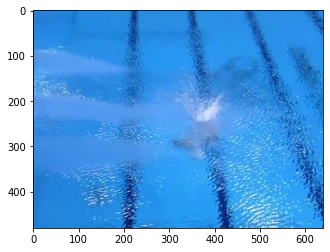

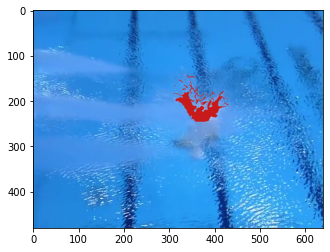

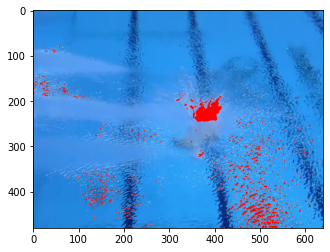

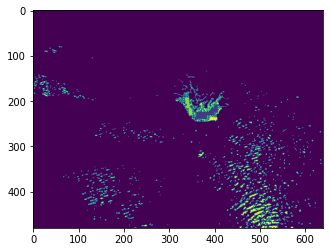

{'frame_name': '_tigfCJFLZg_00032.mp4_0167.0.jpg', 'label_size': 2289, 'splash_size': 8099, 'diff_size': 9075, 'accuracy': -2.9646}


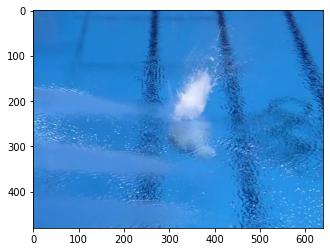

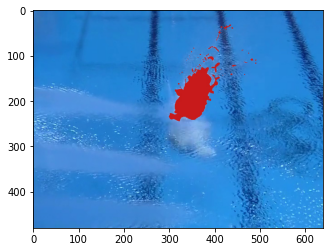

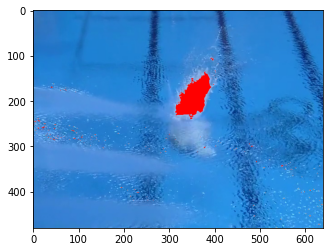

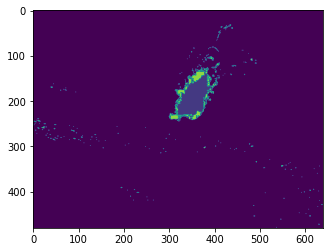

{'frame_name': '_tigfCJFLZg_00005.mp4_0145.0.jpg', 'label_size': 6163, 'splash_size': 4581, 'diff_size': 6660, 'accuracy': -0.0806}


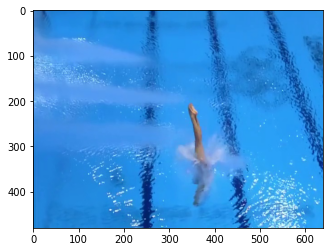

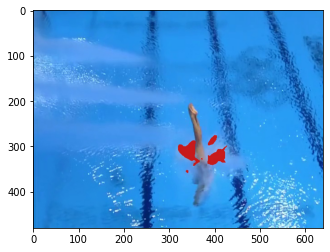

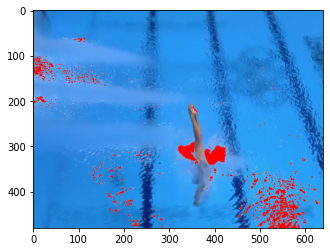

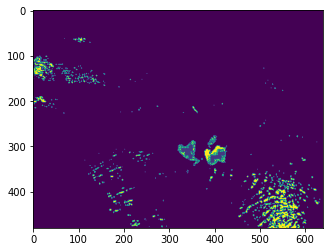

{'frame_name': '_tigfCJFLZg_00118.mp4_0175.0.jpg', 'label_size': 1724, 'splash_size': 9179, 'diff_size': 9519, 'accuracy': -4.5215}


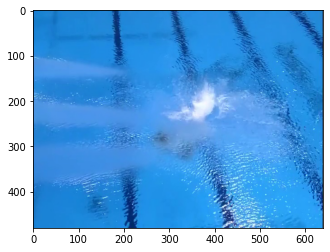

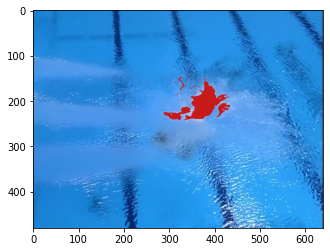

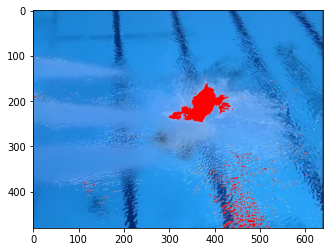

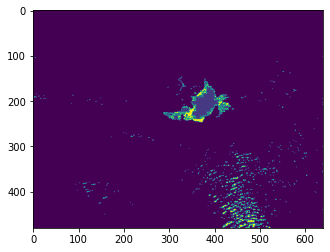

{'frame_name': '_tigfCJFLZg_00054.mp4_0092.0.jpg', 'label_size': 3506, 'splash_size': 7017, 'diff_size': 7406, 'accuracy': -1.1124}


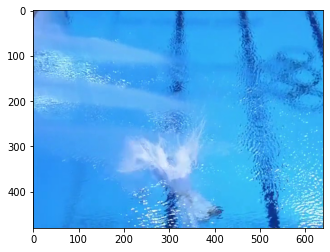

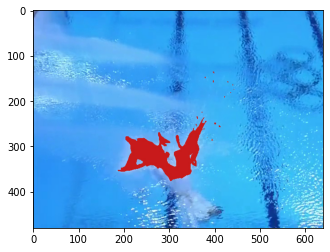

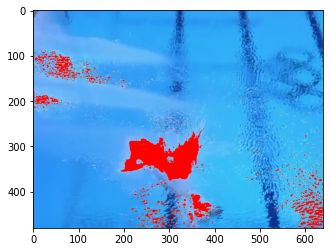

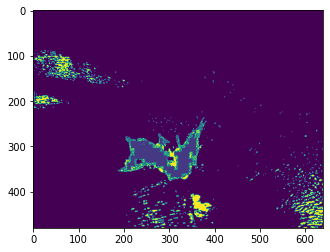

{'frame_name': '_tigfCJFLZg_00014.mp4_0142.0.jpg', 'label_size': 8177, 'splash_size': 17338, 'diff_size': 18196, 'accuracy': -1.2253}


In [7]:
i = 0
while i < 12:
    preddict = predict_and_plot(file_names[i])
    predictions.append(preddict)
    i +=1

In [10]:
predictions

[{'frame_name': '_tigfCJFLZg_00041.mp4_0153.0.jpg',
  'label_size': 2048,
  'splash_size': 4330,
  'diff_size': 4976,
  'accuracy': -1.4297},
 {'frame_name': '_tigfCJFLZg_00045.mp4_0193.0.jpg',
  'label_size': 2497,
  'splash_size': 6146,
  'diff_size': 6711,
  'accuracy': -1.6876},
 {'frame_name': '_tigfCJFLZg_00012.mp4_0140.0.jpg',
  'label_size': 3413,
  'splash_size': 8604,
  'diff_size': 10391,
  'accuracy': -2.0445},
 {'frame_name': '_tigfCJFLZg_00024.mp4_0108.0.jpg',
  'label_size': 2566,
  'splash_size': 7607,
  'diff_size': 9131,
  'accuracy': -2.5585},
 {'frame_name': '_tigfCJFLZg_00113.mp4_0126.0.jpg',
  'label_size': 7316,
  'splash_size': 6831,
  'diff_size': 10247,
  'accuracy': -0.4006},
 {'frame_name': '_tigfCJFLZg_00022.mp4_0141.0.jpg',
  'label_size': 4492,
  'splash_size': 4615,
  'diff_size': 7265,
  'accuracy': -0.6173},
 {'frame_name': '_tigfCJFLZg_00060.mp4_0034.0.jpg',
  'label_size': 1930,
  'splash_size': 5939,
  'diff_size': 6652,
  'accuracy': -2.4466},
 {'f

In [11]:
#predictions.remove(predictions[-1])
len(predictions)

12

In [12]:
# calculate overall accuracy of the model:
all_labels_size = 0
all_diff_sizes = 0
for pre in predictions:
    all_labels_size += pre['label_size']
    all_diff_sizes += pre['diff_size']

model_accuracy = round((all_labels_size - all_diff_sizes) / all_labels_size,4)
print(model_accuracy)

-1.3033
